# Introduction

**Project Motivation:** In this project, we explores what factors effect body fat, furthermore, expect to develop a reliable but simple calculator for body fat. Body fat is a better representative than weight or BMI for obesity which contributes to about half the chronic diseases and increases risks for heart disease, so it is worthwhile to research on the subject. Extant relatively accurate body fat calculating method are always costly and troublesome. For example, Siri’s equation involving measure of body volume which usually derived from underwater submersion. Or like skinfold regression equation requires X-ray scanning techniques.

**Data Discription:** We focus on body fat data file containing only 252 males' accurate bodyfat (%), density (gm/cm^3), ages (yrs), weights (lbs), heights (inches) and some body part circumferences (cm) trying to extract useful information for our body fat calculator. Here, to achieve our goal of simplicity, we just used linear regression model. Linear regression model is an easily understandable model with parameters not hard to interpret. Besides, it is also enough flexible as we could add interaction terms to explain the relationship between different variables.

**The chosen model:** 
$$B(\%) = 0.90*A (cm) - 0.12*W (lbs) - 42,$$ i.e. $$B(\%) = \beta_2*A (cm) - \beta_1*W (lbs) - \beta_0,$$
 where B is the bodyfat percentage (unit: %), A is the abdomen circumference (unit: centimeter), and W is the weight (unit: pound).

Another intuitive way to understand the model: for example, hypothetically there are two males with same weight but one has much larger waistline than another, then normally we infer this person is more fat than the other, that is to say, his bodyfat is assumed to be higher.

# Data Cleaning

In [70]:
Dat = read.csv("BodyFat.csv",header=T)
t(quantile(Dat$HEIGHT)) #quantiles of height in whole dataset
Dat[42,] ## 42th sample has abnormal height value

0%,25%,50%,75%,100%
29.5,68.25,70,72.25,77.75


,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
42,42,31.7,1.025,44,205,29.5,29.9,36.6,106,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4


**Imputation of height on No.42:**

In [71]:
(Dat$HEIGHT[42] = round(sqrt(Dat$WEIGHT[42]*703/Dat$ADIPOSITY[42]),2)) ## Imputed value ## Fisrt-time data cleaning

[1] 69.43

Samples No.48, 96,182 are considered as influential points due to large Cook's distances (showed in detailed version on github). Since we are not sure whether the error came from the observation of DENSITY or BODYFAT, we decided to remove these 3 samples.

In [8]:
Dat.sub = Dat[-c(48,96,182),] ## Second-time cleaned dataset

# Statistical Analysis

**Exploratory Analysis:** Scatterplots between bodyfat and predictors reveals that except for age and height, other variables all have somewhat linear relationship with bodyfat. Also from pairs plot, we can also observe that most of body part circumference variables are linear correlated, which could cause multicolinearity if we include all predictors in the model. But due to limited space, detailed plots are posted in the detailed version on github.

First we only include weight as predictor because of its easy access:

In [16]:
model0 = lm(BODYFAT~WEIGHT, data = Dat.sub)
summary(model0)$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-9.5677973,2.41353759,-3.964221,9.646217e-05
WEIGHT,0.1599011,0.01330163,12.021170,1.633716e-26


In [17]:
round(summary(model0)$r.squared,3) ### R^2 of this simplest model, a bit low

[1] 0.369

Then we want to add on just one of body part circumference variables in order to increase the R-squared but keep the simplicity of our model. And 'abdomen' seems to be the best choice.

In [79]:
frame=NULL
for (i in 8:17){
    model=lm(BODYFAT~WEIGHT + Dat.sub[,i], data = Dat.sub)
    frame=cbind(frame,summary(model)$r.squared)
}
colnames(frame)=names(Dat.sub)[8:17]
round(frame,3) ##The R-squared of linear model after adding on a circumference variable

NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0.37,0.487,0.713,0.388,0.371,0.37,0.392,0.369,0.37,0.389


In [20]:
model1 = lm(BODYFAT~WEIGHT+ABDOMEN, data = Dat.sub)
signif(summary(model1)$coef[,c(1,4)],2) #Estimated coefficients and P-values of model1

,Estimate,Pr(>|t|)
(Intercept),-41.00,2.7e-42
WEIGHT,-0.14,2.5e-11
ABDOMEN,0.91,6.0e-44


In [21]:
round(summary(model1)$r.squared,3)

[1] 0.713

By adding on the interaction term, R-squared only increased 0.012 (see below). Also the effect size of weight and interaction term are close to 0, and P-values are decreased correspondingly. Thus we believe such insignificant improvement does not deserve the complexity. Without the interaction term, our model is simpler to remember and understand.

In [22]:
model1.sub = lm(BODYFAT~WEIGHT*ABDOMEN, data = Dat.sub)
signif(summary(model1.sub)$coef[,c(1,4)],2) #Estimated coefficients and P-values of model2

,Estimate,Pr(>|t|)
(Intercept),-64.0000,8.5e-15
WEIGHT,-0.0031,9.5e-01
ABDOMEN,1.1000,4.1e-29
WEIGHT:ABDOMEN,-0.0013,1.7e-03


In [23]:
round(summary(model1.sub)$r.squared,3)

[1] 0.724

Next we illustrate the residual plot and cook's distance plot of model1 (BODYFAT~WEIGHT+ABDOMEN):

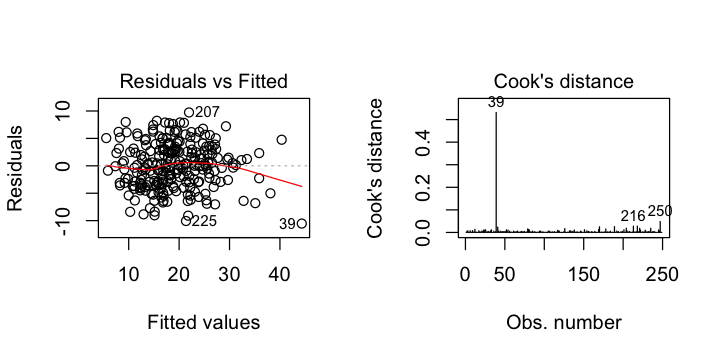

In [75]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,2))
plot(model1, which = c(1,4))

By looking at residual plot and cook's distance, No.39 appeared to be an influential point, thus we decided to delete this sample.

In [26]:
Dat.sub2 = Dat.sub[-39,] ## Third-time data cleaning
model2 = lm(BODYFAT ~ WEIGHT + ABDOMEN, data = Dat.sub2)
signif(summary(model2)$coef[,c(1,2,4)],2) ## Estimates, standard error and P-values of model2 (BODYFAT ~ WEIGHT + ABDOMEN)

,Estimate,Std. Error,Pr(>|t|)
(Intercept),-42.00,2.500,9.7e-44
WEIGHT,-0.12,0.020,3.2e-09
ABDOMEN,0.90,0.052,5.5e-44


In [76]:
round(summary(model2)$r.squared,3) ### R^2

[1] 0.718

We also want to explore the possibility of more than two predictors, so we try adding on one body part circumference variables other than ABDOMEN to the current model and check out the R-squared with different additional variables. Although adding on WRIST can increase the  𝑅2  maximumly, the increment is negligible (0.73 - 0.718 = 0.012). Results are showed below:

In [28]:
frame=NULL
for (i in c(8:9,11:17)){
    model=lm(BODYFAT~WEIGHT+ABDOMEN+Dat.sub2[,i], data = Dat.sub2)
    frame=cbind(frame,summary(model)$r.squared)
}
colnames(frame)=names(Dat.sub)[c(8:9,11:17)]
rownames(frame)="r.squared"
round(frame,3)

,NECK,CHEST,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
r.squared,0.723,0.719,0.718,0.722,0.718,0.718,0.72,0.719,0.73


**Thus the final model is:** $B(\%) = 0.90*A (cm) - 0.12*W (lbs) - 42$ (model2),
 where B is the bodyfat percentage (unit is %), A is the abdomen circumference (unit: centimeter), and W is the weight (unit: pound).

# Diagnositics

#### Residual Plot, QQ-plot and Cook's Distance Plot:
The points in the residual plot are randomly dispersed around the horizontal axis, which shows the model meets the normal assumption of residuals.

The points in the QQ-normal plot almost lie on a straight diagonal line, so the data is roughly normally distributed.

In cook's diatance plot below, there is no obvious influential point.

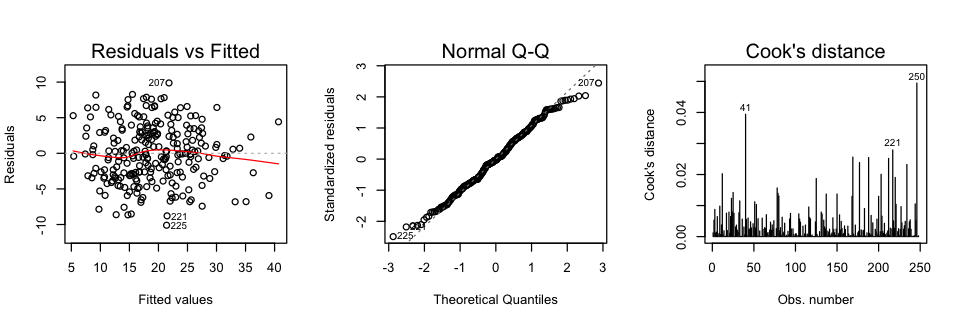

In [52]:
options(repr.plot.width=8, repr.plot.height=2.7)
par(mfrow = c(1,3))
plot(model2,which = c(1,2,4))

# Model Summary and Interpretation

## Relevent summary statistics:

In [38]:
Model = model2
Model.summary = summary(Model)
### The R^2 of the full model: (sufficiently high)
round(Model.summary$r.squared,3) 

[1] 0.718

In [39]:
### The estimates, standard errors and P-values of coefficients:
signif(Model.summary$coef[,c(1,2,4)],2) 

,Estimate,Std. Error,Pr(>|t|)
(Intercept),-42.00,2.500,9.7e-44
WEIGHT,-0.12,0.020,3.2e-09
ABDOMEN,0.90,0.052,5.5e-44


In [40]:
### The confidence intervals of coefficients:
confint(Model)

,2.5 %,97.5 %
(Intercept),-47.1209350,-37.39562882
WEIGHT,-0.1607417,-0.08270941
ABDOMEN,0.7947265,1.00042256


Both coefficients of parameters are highly significant concluded from P-values.

## Interpretation:
**Possible rule of thumb:** 9/10 abdomen circumference minus 1/8 weight, and minus 42.

**Example Usage:** For a male with abdomen circumference of 80 cm and weight of 150 pounds, his estimated bodyfat is  0.89\*80 - 0.12\*150 - 42 = 11.4% (with rule of thumb, 11.25%), which indicates this man should be athletic, maybe does a lot of fitness in daily life. However, if a male's abdomen circumference is 90 cm and still weight of 150, his estimated bodyfat is 0.89\*90 - 0.12\*150 - 42 = 21.3% (with rule of thumb, 20.25%), so he could be a normal-sized person but a little bit fat.

**Inference about Relationship:** Linear relationship clearly exists between the response variable and predictors (P-value of the full model vs. intercept-only model is 4.78e-68). Variation explained by this model achieved more than 70%.

**Strength of our data analysis:**
1. Simplicity: Only two independent variables are included, which makes the model simple enough to be understood. And both variables can be easily measured in our daily life, which assure the practicability.
2. Assumption verification: We used QQ-plot to check normality of residuals which turns out to be reasonable and ploted residuals directly to verify homoskedasticity. Verification of both assumptions shows reliability of our model.
3. Explanation of variation: Large R-square (0.718) indicates that the model is quite accurate to predict body fat.

**Weakness:**
1. Sample size is small. We only have 252 samples to bulid up the model.
2. Scope of application is narrow. Since only males are measured in the dataset, this model cannot be applied on women.
3. Colinearity between two predictor variables almost surely exists. We gave up accounting for this colinearity in order to maintain simplicity of the model.
4. Further complex models like LASSO or ridge regression haven't been tried.
5. This model doesn't make sure predicted bodyfat is positive!